In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt
from track import *
tkwargs = {
    "dtype" : torch.double
}
import time
np.set_printoptions(precision= 16, suppress=False)
torch.set_printoptions(precision= 16, sci_mode=True)
torch.__version__, np.__version__

('1.10.2', '1.22.2')

In [2]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

# Quad strength optimization

In [3]:
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)

# Initial beam distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

# Lattice fixed parameters
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L=torch.tensor(L_d, **tkwargs))

In [4]:
# Objective function (O.F.)
def beamsize(k1s):
    """Returns std(sqrt(x^2+y^2)) after lattice composed by len(k1s)+1 drifts with
    len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    for k1 in k1s:
        lattice.append( Quadrupole(L=torch.tensor(L_q, **tkwargs), K1=k1) )
        lattice.append( drift )
    p_out = track_a_lattice(p_in, lattice)[-1]
    return torch.std(torch.sqrt(p_out.x**2+p_out.y**2))

# Model to optimize using torch.nn.Module
class BeamSizeModel(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s):
        super().__init__()
        self.register_parameter('k1s',torch.nn.Parameter(k1s))
    def forward(self):
        return beamsize(self.k1s) + torch.abs(torch.mean(self.k1s))*1e-3  # O.F.

In [5]:
def train_model(model, training_iter):
    history_param = [None] * training_iter
    history_loss = [None] * training_iter
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward()
        if i%10==0: #print each 10 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss.item()
            ))
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        optimizer.step()
        

    return np.asarray(history_param), np.asarray(history_loss)

In [6]:
%%time
# Initial k1s
k1s = torch.zeros(10, **tkwargs)

# Optimization
model = BeamSizeModel(k1s)
params, loss = train_model(model, 500)

k1s : Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64,
       requires_grad=True)
Iter 1/500 - Loss: 0.01086 
Iter 11/500 - Loss: 0.01106 
Iter 21/500 - Loss: 0.01097 
Iter 31/500 - Loss: 0.01089 
Iter 41/500 - Loss: 0.01087 
Iter 51/500 - Loss: 0.01084 
Iter 61/500 - Loss: 0.01077 
Iter 71/500 - Loss: 0.01036 
Iter 81/500 - Loss: 0.00785 
Iter 91/500 - Loss: 0.00323 
Iter 101/500 - Loss: 0.00223 
Iter 111/500 - Loss: 0.00189 
Iter 121/500 - Loss: 0.00173 
Iter 131/500 - Loss: 0.00155 
Iter 141/500 - Loss: 0.00140 
Iter 151/500 - Loss: 0.00128 
Iter 161/500 - Loss: 0.00117 
Iter 171/500 - Loss: 0.00106 
Iter 181/500 - Loss: 0.00095 
Iter 191/500 - Loss: 0.00083 
Iter 201/500 - Loss: 0.00073 
Iter 211/500 - Loss: 0.00065 
Iter 221/500 - Loss: 0.00060 
Iter 231/500 - Loss: 0.00054 
Iter 241/500 - Loss: 0.00050 
Iter 251/500 - Loss: 0.00046 
Iter 261/500 - Loss: 0.00043 
Iter 271/500 - Loss: 0.00041 
Iter 281/500 - Loss: 0.00042 
Iter 291/500 - L

Text(0.5, 0, 'n_iter')

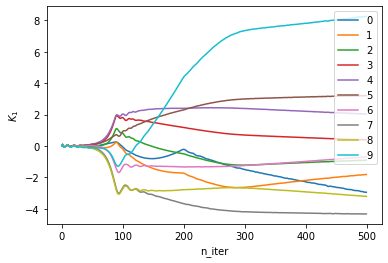

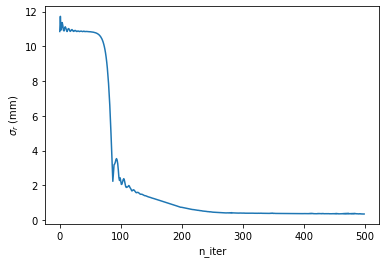

In [7]:
# Plot O.F. and parameters as function of iteration number
for i in range(len(k1s)):
    plt.plot(np.arange(len(params[:,0])), params[:,i], label=str(i))
plt.legend()
plt.ylabel(r'$K_1$')
plt.xlabel('n_iter')
plt.figure()
plt.plot(np.arange(len(loss)), loss*1000)
plt.ylabel(r'$\sigma_r$ (mm)')
plt.xlabel('n_iter')
#params, loss

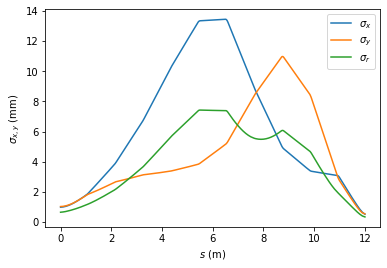

In [8]:
# plot beamsize for final config
lattice = [drift]
k1s = torch.tensor(params[-1], **tkwargs)
for k1 in k1s:
    lattice.append( Quadrupole(L=torch.tensor(L_q, **tkwargs), K1=k1) )
    lattice.append( drift )
n=10
stubbed_lattice = stub_lattice(lattice, n)
all_p = track_a_lattice(p_in, stubbed_lattice)
stdx, stdy, stdr, s = [torch.std(par.x) for par in all_p], [torch.std(par.y) for par in all_p], [torch.std(torch.sqrt(par.x**2+par.y**2)) for par in all_p], [par.s for par in all_p]
plt.plot(s, np.array(stdx)*1000, label=r'$\sigma_x$')
plt.plot(s, np.array(stdy)*1000, label=r'$\sigma_y$')
plt.plot(s, np.array(stdr)*1000, label=r'$\sigma_r$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

# Offset estimation

In [9]:
# 1 quad (dqd)
# ground truth beamline: show focusing case (solution), add random fixed x-offsets, track beam again: 2D histogram
# model 2: give beam propagation data (2D histogram), try to get offsets st histogram is close. 
# Loss: KL-divergence: comparse prob distros